# Randomized Image Sampling for Explanations (RISE)

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm

from keras.applications.resnet50 import preprocess_input

/home/devin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Change code below to incorporate your *model* and *input processing*

### Define your model here:

In [17]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

class DetectionModel(nn.Module):
    
    def __init__(self):
        super(DetectionModel, self).__init__()
        self.resnet = models.resnet18()
        self.resnet.fc = nn.Linear(512, 2)
        
    def run_on_batch(self, x):
        x = x.float()
        return self.forward(x)
        
    def forward(self, x):
        x = self.resnet(x)
        x = F.log_softmax(x, dim=1)
        return x
    
model = DetectionModel()
model.load_state_dict(torch.load('./saved_models/resnet-on-sdnet18.pt'))
model.eval()

model.input_size = (224, 224)

### Load and preprocess image

In [3]:
from PIL import Image
from torchvision import transforms

In [4]:
"""def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x"""

def load_img(path):
    img = Image.open(path)
    trans = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    trans1 = transforms.ToTensor()
    trans2 = transforms.Resize((224, 224))
    x = trans(trans1(trans2(img)))
    x = np.array([np.transpose(x.numpy())])
    x = torch.from_numpy(x).float()
    return img, x

---

## RISE

In [18]:
def generate_masks(N, s, p1):
    cell_size = np.ceil(np.array(model.input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model.input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + model.input_size[0], y:y + model.input_size[1]]
    masks = masks.reshape(-1, *model.input_size, 1)
    masks = torch.from_numpy(masks)
    return masks

In [19]:
batch_size = 100

def explain(model, inp, masks):
    with torch.no_grad():
        preds = []
        # Make sure multiplication is being done for correct axes
        masked = inp.double() * masks
        masked = np.transpose(masked, (0, 3, 2, 1))
        for i in tqdm(range(0, N, batch_size), desc='Explaining'):
            minput = masked[i:min(i+batch_size, N)]
            preds.append(model.run_on_batch(minput))
        preds = np.concatenate(preds)
        sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
        sal = sal / N / p1
    
        return sal

---

## Running explanations

In [20]:
def class_name(idx):
    classes = ('Cracked', 'Not Cracked')
    return classes[idx]

In [8]:
img, x = load_img('cracked2.jpg')

In [9]:
N = 2000
s = 8
p1 = 0.5
masks = generate_masks(2000, 8, 0.5)

Generating masks: 100%|██████████| 2000/2000 [00:03<00:00, 608.15it/s]


In [10]:
sal = explain(model, x, masks)

Explaining: 100%|██████████| 125/125 [05:33<00:00,  2.67s/it]


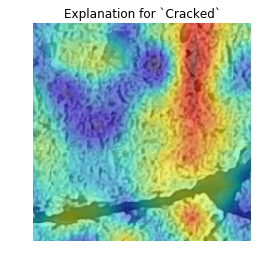

In [12]:
class_idx = 0
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.savefig('foo.png')
# plt.colorbar()
plt.show()

In [ ]:
"""
Generate maps for folder of images
"""

import os

source = "./cracks"

files = os.listdir(source)
for i, f in enumerate(files):
    img, x = load_img(source + "/" + f)
    
    N = 2000
    s = 8
    p1 = 0.5
    masks = generate_masks(2000, 8, 0.5)
    
    sal = explain(model, x, masks)
    
    class_idx = 0
    plt.title('Explanation for `{}`'.format(class_name(class_idx)))
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
    plt.savefig('./cracks_saliency/cracked_saliency_' + str(i+2) + '.png')
    # plt.colorbar()
    plt.show()



Generating masks:   0%|          | 0/2000 [00:00<?, ?it/s]

Generating masks:   3%|▎         | 56/2000 [00:00<00:03, 548.83it/s]

Generating masks:   6%|▌         | 114/2000 [00:00<00:03, 560.70it/s]

Generating masks:   9%|▊         | 171/2000 [00:00<00:03, 563.68it/s]

Generating masks:  11%|█▏        | 228/2000 [00:00<00:03, 564.93it/s]

Generating masks:  14%|█▍        | 284/2000 [00:00<00:03, 562.04it/s]

Generating masks:  17%|█▋        | 344/2000 [00:00<00:02, 568.03it/s]

Generating masks:  20%|██        | 404/2000 [00:00<00:02, 572.01it/s]

Generating masks:  23%|██▎       | 466/2000 [00:00<00:02, 576.63it/s]

Generating masks:  26%|██▋       | 525/2000 [00:00<00:02, 576.38it/s]

Generating masks:  29%|██▉       | 583/2000 [00:01<00:02, 576.64it/s]

Generating masks:  32%|███▏      | 644/2000 [00:01<00:02, 579.14it/s]

Generating masks:  35%|███▌      | 702/2000 [00:01<00:02, 579.12it/s]

Generating masks:  38%|███▊      | 763/2000 [00:01<00:02, 580.68it/s]

Generating masks